# Translate Handwritten Text

## Recognize handwritten text

In [1]:
# Set image_url to the URL of an image that you want to analyze.
#image_url = "https://upload.wikimedia.org/wikipedia/commons/d/dd/Cursive_Writing_on_Notebook_paper.jpg"
image_url = "https://storageaccountformoddemo.blob.core.windows.net/ocr/Photo_01_small.jpg"

In [2]:
vision_subscription_key = ""
translation_subscription_key = ""
speech_subscription_key = ""

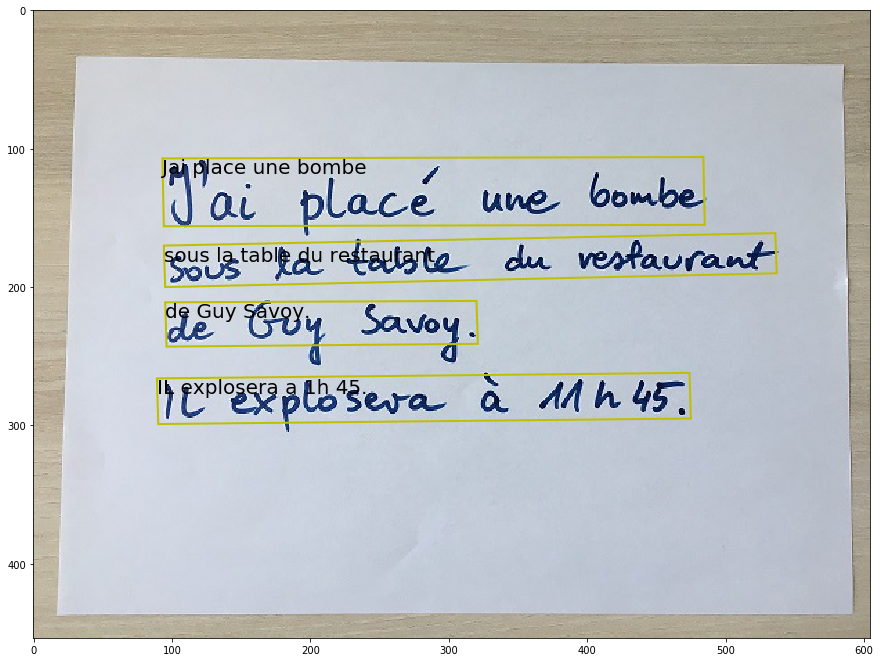

In [3]:
import requests
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

from PIL import Image
from io import BytesIO
import urllib.request
import json


vision_base_url = "https://westeurope.api.cognitive.microsoft.com/vision/v2.0/"
text_recognition_url = vision_base_url + "read/core/asyncBatchAnalyze"

headers = {'Ocp-Apim-Subscription-Key': vision_subscription_key}
data    = {'url': image_url}
response = requests.post(text_recognition_url, headers=headers, json=data)
response.raise_for_status()

# Extracting handwritten text requires two API calls: One call to submit the
# image for processing, the other to retrieve the text found in the image.

# Holds the URI used to retrieve the recognized text.
operation_url = response.headers["Operation-Location"]

# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    #print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll= False 
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll= False

polygons=[]
if ("recognitionResults" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
        for line in analysis["recognitionResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
plt.figure(figsize=(15, 15))
image = Image.open(urllib.request.urlopen(image_url))
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
        for i in range(0, len(polygon[0]), 2)]
    text     = polygon[1]
    patch    = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")

In [4]:
if ("recognitionResults" in analysis):
    recognized_texts = [line["text"] for line in analysis["recognitionResults"][0]["lines"]]
    print(recognized_texts)

['Jai place une bombe', 'sous la table du restaurant', 'de Guy Savoy.', 'IL explosera a 1h 45.']


## Translate to English

In [5]:
translation_base_url = 'https://api.cognitive.microsofttranslator.com'
path = '/translate?api-version=3.0&to=en'
translation_full_url = translation_base_url + path

headers = {
    'Ocp-Apim-Subscription-Key': translation_subscription_key,
    'Content-type': 'application/json'
}

body = [{
    'text': ' '.join(recognized_texts)
}]

request = requests.post(translation_full_url, headers=headers, json=body)
response = request.json()
print(json.dumps(response, sort_keys=True, indent=4, ensure_ascii=False, separators=(',', ': ')))

[
    {
        "detectedLanguage": {
            "language": "fr",
            "score": 1.0
        },
        "translations": [
            {
                "text": "I put a bomb under the table of guy Savoy's restaurant. It will explode at 1h 45.",
                "to": "en"
            }
        ]
    }
]


In [6]:
translated_text = response[0]['translations'][0]['text']
#translated_text = "Podłożyłem bombę pod stołem w Restauracji Guy Savoy. Eksploduje o godzinie 11:45"

## Say it out loud

In [7]:
import os, requests, time
from xml.etree import ElementTree

In [8]:
class TextToSpeech(object):
    def __init__(self, subscription_key):
        self.subscription_key = subscription_key
        #self.tts = input("What would you like to convert to speech: ")
        self.timestr = time.strftime("%Y%m%d-%H%M")
        self.access_token = None

    '''
    The TTS endpoint requires an access token. This method exchanges your
    subscription key for an access token that is valid for ten minutes.
    '''
    def get_token(self):
        fetch_token_url = "https://westeurope.api.cognitive.microsoft.com/sts/v1.0/issueToken"
        headers = {
            'Ocp-Apim-Subscription-Key': self.subscription_key
        }
        response = requests.post(fetch_token_url, headers=headers)
        self.access_token = str(response.text)

    def save_audio(self, text_to_speech):
        base_url = 'https://westeurope.tts.speech.microsoft.com/'
        path = 'cognitiveservices/v1'
        constructed_url = base_url + path
        headers = {
            'Authorization': 'Bearer ' + self.access_token,
            'Content-Type': 'application/ssml+xml',
            'X-Microsoft-OutputFormat': 'riff-24khz-16bit-mono-pcm',
            'User-Agent': 'YOUR_RESOURCE_NAME'
        }
        xml_body = ElementTree.Element('speak', version='1.0')
        xml_body.set('{http://www.w3.org/XML/1998/namespace}lang', 'en-us')
        voice = ElementTree.SubElement(xml_body, 'voice')
        voice.set('{http://www.w3.org/XML/1998/namespace}lang', 'en-GB')
        #voice_name = 'en-US-Guy24kRUS'
        voice_name = 'en-GB-George-Apollo'
        #voice_name = 'pl-PL-PaulinaRUS'
        voice.set('name', voice_name) # Short name for 'Microsoft Server Speech Text to Speech Voice'
        voice.text = text_to_speech
        body = ElementTree.tostring(xml_body)

        response = requests.post(constructed_url, headers=headers, data=body)
        '''
        If a success response is returned, then the binary audio is written
        to file in your working directory. It is prefaced by sample and
        includes the date.
        '''
        if response.status_code == 200:
            audio_filename = 'sample-' + self.timestr + '.wav'
            with open(audio_filename, 'wb') as audio:
                audio.write(response.content)
                print("\nStatus code: " + str(response.status_code) + "\nYour TTS is ready for playback.\n")
                return audio_filename
        else:
            print("\nStatus code: " + str(response.status_code) + "\nSomething went wrong. Check your subscription key and headers.\n")

            
app = TextToSpeech(speech_subscription_key)
app.get_token()
audio_filename = app.save_audio(translated_text)


Status code: 200
Your TTS is ready for playback.



In [9]:
import IPython.display as ipd
ipd.Audio(audio_filename)